In [1]:
import h5py
import numpy as np
import pandas as pd
from pathlib import Path

%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt


def show_scatter(data: np.ndarray, color: np.ndarray):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.set_facecolor("white")
    ff = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=color)
    plt.colorbar(ff)
    plt.show()

# Load data

In [3]:
paths = sorted(
    Path("/homes/atrifan/sars-cov2-virion/h5_files/").glob("*_virion.h5"),
    key=lambda p: int(p.name.split("_")[0][1:]),  # s1_virion.h5 -> 1
)

positions, rmsds = [], []
for p in paths:
    with h5py.File(p, "r") as f:
        positions.append(f["point_cloud"][...])
        rmsds.append(f["rmsd"][...])

# Concatenate trajectories of individual spike proteins
positions = np.concatenate(positions)
rmsds = np.concatenate(rmsds)

print(positions.shape)
print(rmsds.shape)

(19704, 3, 3375)
(19704,)


In [4]:
# Label by index of data file
spike_labels = np.array([np.ones((821)) * i for i in range(len(paths))]).reshape(
    (24 * 821,)
)

# Preprocess raw positions

## First align the positions using kabsch iterative means alignment

In [10]:
from mdlearn.data.preprocess.align import iterative_means_align

In [11]:
itr, avg_coords, e_rmsd, coords = iterative_means_align(
    positions, eps=0.001, max_iter=10, num_workers=30, verbose=True
)

Shape of coords array in iterative_means: (19704, 3, 3375)
Iteration #1 with an error of 2399.572998046875
Iteration #2 with an error of 12.457925796508789
Iteration #3 with an error of 0.025916362181305885
Iteration #4 with an error of 0.0005742502980865538


## Then use SD2 to run PCA on the aligned coordinates

In [6]:
from mdlearn.data.preprocess.decorrelation.spatial import SD2

In [7]:
Y, S, B, U = SD2(coords.reshape(-1, 3375 * 3), m=3375 * 3, verbose=True)

2nd order Spatial Decorrelation -> Looking for 10125 sources
2nd order Spatial Decorrelation -> Removing the mean value
2nd order Spatial Decorrelation -> Whitening the data


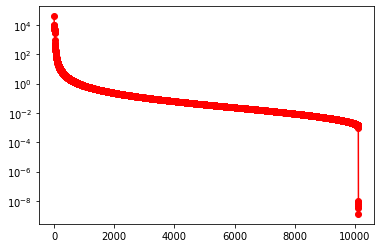

In [10]:
plt.semilogy(S, "ro-")

## Then use SD4 to further decorrelate the data

In [12]:
from mdlearn.data.preprocess.decorrelation.spatial import SD4

In [ ]:
# Use the first 60 principal components
W = SD4(Y[0:60, :], m=60, U=U[0:60, :], verbose=False)

In [19]:
np.save("W_spike.npy", W)

In [16]:
coordsAll = np.reshape(coords, (len(coords), coords.shape[1] * coords.shape[2])).T
avgCoordsAll = np.mean(coordsAll, 1)
tmpAll = np.reshape(
    np.tile(avgCoordsAll, coords.shape[0]),
    (coords.shape[0], coords.shape[1] * coords.shape[2]),
).T
caDevsMDall = coordsAll - tmpAll
caDevsMDall.shape

(10125, 19704)

In [17]:
ZPrj4 = W.dot(caDevsMDall)
ZPrj4.shape

(60, 19704)

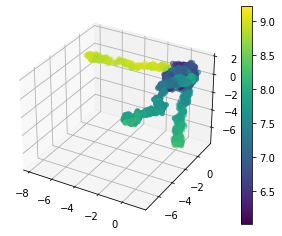

In [20]:
show_scatter(ZPrj4.T[:, :3], e_rmsd[-1])

# Now use an autoencoder to model the nonlinear portions

In [2]:
from mdlearn.nn.models.ae.linear import LinearAETrainer

In [5]:
trainer = LinearAETrainer(
    input_dim=60,
    latent_dim=3,
    hidden_neurons=[32, 16, 8],
    epochs=500,
    verbose=False,
    checkpoint_log_every=10,
    plot_log_every=10,
    plot_n_samples=5000,
    device="cpu",
)

In [6]:
vars(trainer)

{'seed': 42,
 'scalar_dset_names': [],
 'in_gpu_memory': False,
 'num_data_workers': 0,
 'persistent_workers': False,
 'prefetch_factor': 2,
 'split_pct': 0.8,
 'batch_size': 128,
 'shuffle': True,
 'device': device(type='cpu'),
 'optimizer_name': 'RMSprop',
 'optimizer_hparams': {'lr': 0.001, 'weight_decay': 1e-05},
 'scheduler_name': None,
 'scheduler_hparams': {},
 'epochs': 500,
 'verbose': False,
 'clip_grad_max_norm': 10.0,
 'checkpoint_log_every': 10,
 'plot_log_every': 10,
 'plot_n_samples': 5000,
 'plot_method': 'TSNE',
 'train_subsample_pct': 1.0,
 'valid_subsample_pct': 1.0,
 'use_wandb': False,
 'model': LinearAE(
   (encoder): DenseNet(
     (model): Sequential(
       (0): Linear(in_features=60, out_features=32, bias=True)
       (1): ReLU()
       (2): Linear(in_features=32, out_features=16, bias=True)
       (3): ReLU()
       (4): Linear(in_features=16, out_features=8, bias=True)
       (5): ReLU()
       (6): Linear(in_features=8, out_features=3, bias=True)
     )
   

In [32]:
X = ZPrj4.T
scalars = {"rmsd": rmsds}
X.shape

(19704, 60)

In [24]:
np.save("X_spike.npy", X)

In [ ]:
trainer.fit(X, scalars, "./spike-run-1")

<AxesSubplot:>

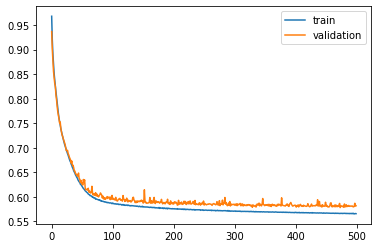

In [34]:
pd.DataFrame(trainer.loss_curve_).plot()

In [35]:
pd.DataFrame(trainer.loss_curve_).to_csv("./spike-run-1/loss.csv")

## Run inference to generate latent embeddings

In [7]:
X = np.load("X_spike.npy")
z, loss = trainer.predict(
    X, checkpoint="./spike-run-1/checkpoints/checkpoint-epoch-500.pt"
)
loss

0.5645293849400985

In [8]:
z.shape

(19704, 3)

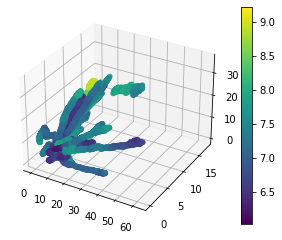

In [37]:
# e_rmsd from aligned structure
show_scatter(z, e_rmsd[-1])

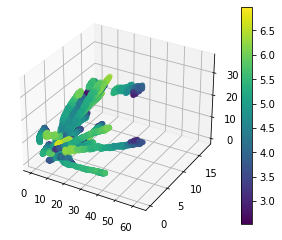

In [38]:
# RMSD to reference state
show_scatter(z, rmsds)

In [39]:
from mdlearn.visualize import plot_scatter

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

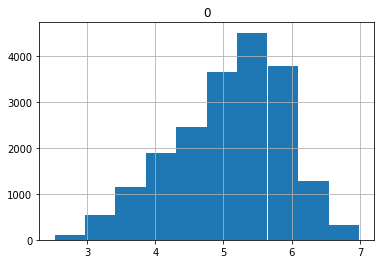

In [63]:
pd.DataFrame(rmsds).hist()

In [ ]:
plot_scatter(
    z, {"e_rmsd": e_rmsd[-1], "rmsd": rmsds, "spikes": spike_labels}, "rmsd"
).show()

In [ ]:
plot_scatter(
    z, {"e_rmsd": e_rmsd[-1], "rmsd": rmsds, "spikes": spike_labels}, "e_rmsd"
).show()

In [ ]:
plot_scatter(
    z, {"e_rmsd": e_rmsd[-1], "rmsd": rmsds, "spikes": spike_labels}, "spikes"
).show()

In [ ]:
plot_scatter(
    ZPrj4.T[:, :3],
    {"e_rmsd": e_rmsd[-1], "rmsd": rmsds, "spikes": spike_labels},
    "e_rmsd",
).show()

In [ ]:
plot_scatter(
    ZPrj4.T[:, :3],
    {"e_rmsd": e_rmsd[-1], "rmsd": rmsds, "spikes": spike_labels},
    "rmsd",
).show()

In [ ]:
plot_scatter(
    ZPrj4.T[:, :3],
    {"e_rmsd": e_rmsd[-1], "rmsd": rmsds, "spikes": spike_labels},
    "spikes",
).show()